In [1]:
# Packages
import tsplib95
import random
import matplotlib.pyplot as plt
import os
import gzip

URV                                                                            MESIIA

Neural and Evolutionary Computation (NEC)
Assignment 4: Optimization with Genetic Algorithm

Teachers: Dr. Jordi Duch, Dr. Sergio Gomez

Student: Natzaret Gálvez Rísquez

Implementing a genetic algorithm for the Traveling Salesman Problem (TSP) using the TSPLIB library 

In [2]:
# Dataset 1
# File path
tsp_file_path = 'C:/Users/Gari/Desktop/Assignments_NEC/A4/burma14.tsp'

# Load the dataset
dataset1 = tsplib95.load(tsp_file_path)

In [3]:
# Dataset 2
# File path
tsp_file_path = 'C:/Users/Gari/Desktop/Assignments_NEC/A4/bays29.tsp'

# Load the dataset
dataset2 = tsplib95.load(tsp_file_path)

In [4]:
# Dataset 3
# File path
tsp_file_path = 'C:/Users/Gari/Desktop/Assignments_NEC/A4/eil101.tsp'

# Load the dataset
dataset3 = tsplib95.load(tsp_file_path)

Genetic algorithm  for solving the Traveling Salesman Problem (TSP) using permutation representation and various selection, mutation, and crossover techniques

In [5]:
import numpy as np

def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def compute_distances(node_coords):
    num_cities = len(node_coords)
    distances = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distances[i, j] = euclidean_distance(node_coords[i], node_coords[j])
    return distances

def parse_dataset(dataset):
    node_coords = {}
    for node in dataset.node_coords:
        node_coords[node] = dataset.node_coords[node]
    return node_coords

def total_distance(solution, distances):
    solution = np.array(solution, dtype=int)  # Convert solution to a NumPy array of integers
    n = len(solution)
    distance = 0
    for i in range(n):
        distance += distances[solution[i], solution[(i + 1) % n]]
    return distance

def roulette_wheel_selection(population, distances):
    fitness_values = np.array([1 / total_distance(individual, distances) for individual in population])
    probabilities = fitness_values / np.sum(fitness_values)
    selected_index = np.random.choice(len(population), p=probabilities)
    return population[selected_index]

def tournament_selection(population, distances, tournament_size=5):
    population_flat = [individual for individual in population]  # Flatten the population list
    tournament_candidates_indices = np.random.choice(len(population_flat), size=tournament_size, replace=False)
    tournament_candidates = [list(population_flat[index]) for index in tournament_candidates_indices]
    tournament_fitness = [1 / total_distance(individual, distances) for individual in tournament_candidates]
    winner_index = np.argmax(tournament_fitness)
    return tournament_candidates[winner_index]

def partially_mapped_crossover(parent1, parent2):
    n = len(parent1)
    start, end = sorted(np.random.choice(n, 2, replace=False))
    child1, child2 = [-1] * n, [-1] * n
    child1[start:end + 1] = parent1[start:end + 1]
    child2[start:end + 1] = parent2[start:end + 1]

    for i in range(n):
        if not np.any(np.equal(parent2[i], child1)):
            index = i
            while np.any(child1[index] != -1):
                index = np.where(parent1 == parent2[index])[0][0]
            child1[index] = parent2[i]
        if not np.any(np.equal(parent1[i], child2)):
            index = i
            while np.any(child2[index] != -1):
                index = np.where(parent2 == parent1[index])[0][0]
            child2[index] = parent1[i]

    return child1, child2

def order_crossover(parent1, parent2):
    n = len(parent1)
    start, end = sorted(np.random.choice(n, 2, replace=False))
    child1, child2 = [-1] * n, [-1] * n
    child1[start:end + 1] = parent1[start:end + 1]
    child2[start:end + 1] = parent2[start:end + 1]

    for i in range(n):
        if child1[i] == -1:
            idx = (end + 1) % n
            while parent2[idx] in child1:
                idx = (idx + 1) % n
            child1[i] = parent2[idx]

        if child2[i] == -1:
            idx = (end + 1) % n
            while parent1[idx] in child2:
                idx = (idx + 1) % n
            child2[i] = parent1[idx]

    return child1, child2

def inversion_mutation(solution):
    n = len(solution)
    start, end = sorted(np.random.choice(n, 2, replace=False))
    return np.concatenate((solution[:start], np.flip(solution[start:end + 1]), solution[end + 1:]))

def swap_mutation(solution):
    n = len(solution)
    idx1, idx2 = np.random.choice(n, 2, replace=False)
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
    return solution

def genetic_algorithm(distances, population_size=100, mutation_rate=0.01, max_generations=100):
    n = distances.shape[0]
    population = [list(np.random.permutation(range(n))) for _ in range(population_size)]

    best_distances = []
    best_solution = None

    for generation in range(max_generations):
        selected_parents = [roulette_wheel_selection(population, distances), tournament_selection(population, distances)]

        child1_pmx, child2_pmx = partially_mapped_crossover(selected_parents[0], selected_parents[1])

        mutation_chance = np.random.rand()
        if mutation_chance < mutation_rate:
            child1_pmx = inversion_mutation(child1_pmx)
        mutation_chance = np.random.rand()
        if mutation_chance < mutation_rate:
            child2_pmx = inversion_mutation(child2_pmx)

        distances_population = [total_distance(individual, distances) for individual in population]
        worst1_idx = np.argmax(distances_population)
        population.pop(worst1_idx)

        distances_population = [total_distance(individual, distances) for individual in population]
        worst2_idx = np.argmax(distances_population)
        population.pop(worst2_idx)

        population.extend([child1_pmx, child2_pmx])

        population.sort(key=lambda x: total_distance(x, distances))
        if best_solution is None or total_distance(population[0], distances) < total_distance(best_solution, distances):
            best_solution = population[0]
        
        best_distances.append(total_distance(population[0], distances))

    return best_solution, best_distances


In [6]:
# Function to create problem instances with different sizes

def generate_problem_instance(num_cities):
    # Generate random coordinates for cities
    node_coords = {i: (np.random.uniform(0, 100), np.random.uniform(0, 100)) for i in range(num_cities)}
    return node_coords


Problem with 14-city problem

Parameters Set 1:
Population Size: 100
Mutation Rate: 0.01
Max Generations: 100
Best Solution: [4, 11, 0, 9, 6, 7, 1, 8, 12, 13, 3, 2, 5, 10]
Best Distance: [485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 485.0939018308125, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.2205420396431, 466.22

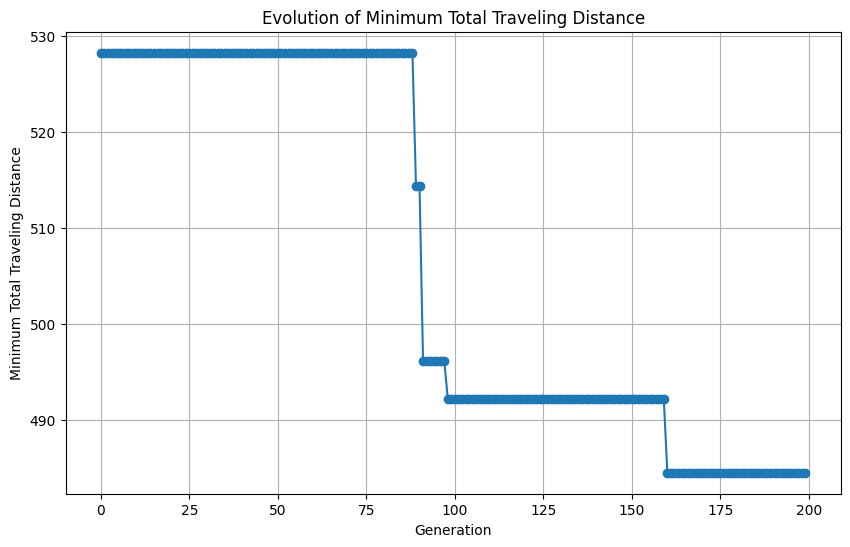

In [18]:
# Define the number of cities and coordinates for dataset 1
num_cities_dataset1 = 14

# Generate dataset 1
dataset1 = generate_problem_instance(num_cities_dataset1)
distances_dataset1 = compute_distances(dataset1)

# Define parameter combinations for dataset 1
parameter_combinations_dataset1 = [
    {'population_size': 100, 'mutation_rate': 0.01, 'max_generations': 100},
    {'population_size': 200, 'mutation_rate': 0.01, 'max_generations': 150},
    {'population_size': 150, 'mutation_rate': 0.02, 'max_generations': 100},
    {'population_size': 250, 'mutation_rate': 0.02, 'max_generations': 150},
    {'population_size': 100, 'mutation_rate': 0.03, 'max_generations': 150},
    {'population_size': 200, 'mutation_rate': 0.03, 'max_generations': 200}
]

results_dataset1 = []

# Iterate over parameter combinations and execute genetic algorithm
for params in parameter_combinations_dataset1:
    population_size = params['population_size']
    mutation_rate = params['mutation_rate']
    max_generations = params['max_generations']
    
    best_solution_dataset1, best_distances_dataset1 = genetic_algorithm(distances_dataset1, population_size, mutation_rate, max_generations)
    results_dataset1.append({'parameters': params, 'best_solution': best_solution_dataset1, 'best_distances': best_distances_dataset1})

for i, result in enumerate(results_dataset1):
    print(f"Parameters Set {i + 1}:")
    print("Population Size:", result['parameters']['population_size'])
    print("Mutation Rate:", result['parameters']['mutation_rate'])
    print("Max Generations:", result['parameters']['max_generations'])
    print("Best Solution:", result['best_solution'])
    print("Best Distance:", result['best_distances'])
    print()

import matplotlib.pyplot as plt

# Plot the evolution of the minimum total traveling distance
plt.figure(figsize=(10, 6))
plt.plot(best_distances_dataset1, marker='o', linestyle='-')
plt.title("Evolution of Minimum Total Traveling Distance")
plt.xlabel("Generation")
plt.ylabel("Minimum Total Traveling Distance")
plt.grid(True)
plt.show()


Problem with 10-30 (29) city problem

Parameters Set 1:
Population Size: 100
Mutation Rate: 0.01
Max Generations: 100
Best Solution: [26, 24, 23, 18, 15, 27, 16, 13, 5, 28, 6, 25, 8, 2, 1, 19, 0, 3, 7, 12, 20, 9, 14, 4, 17, 10, 21, 22, 11]
Best Distance: [1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 1239.2396304201714, 12

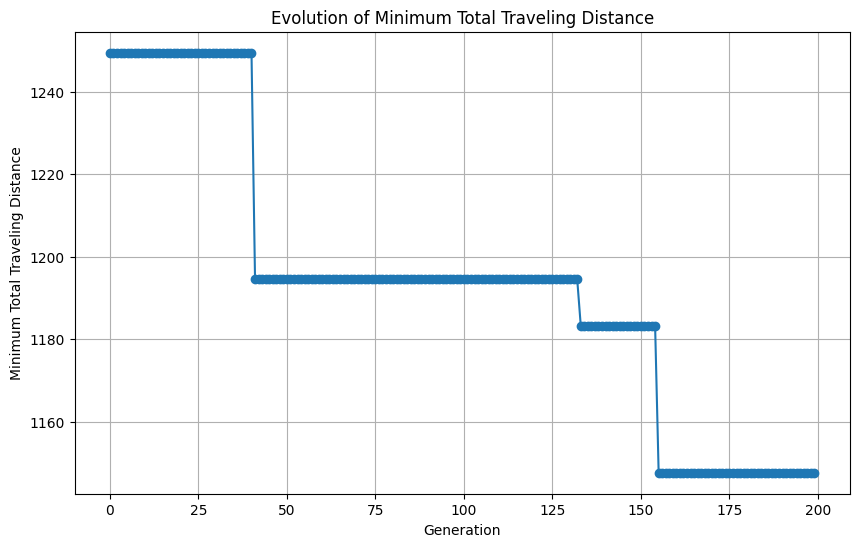

In [20]:
# Define the number of cities and coordinates for dataset 2
num_cities_dataset2 = 29

# Generate dataset 1
dataset2 = generate_problem_instance(num_cities_dataset2)
distances_dataset2 = compute_distances(dataset2)

# Define parameter combinations for dataset 2
parameter_combinations_dataset = [
    {'population_size': 100, 'mutation_rate': 0.01, 'max_generations': 100},
    {'population_size': 200, 'mutation_rate': 0.01, 'max_generations': 150},
    {'population_size': 150, 'mutation_rate': 0.02, 'max_generations': 100},
    {'population_size': 250, 'mutation_rate': 0.02, 'max_generations': 150},
    {'population_size': 100, 'mutation_rate': 0.03, 'max_generations': 150},
    {'population_size': 200, 'mutation_rate': 0.03, 'max_generations': 200}
]

results_dataset = []

# Iterate over parameter combinations and execute genetic algorithm
for params in parameter_combinations_dataset1:
    population_size = params['population_size']
    mutation_rate = params['mutation_rate']
    max_generations = params['max_generations']
    
    best_solution_dataset, best_distances_dataset = genetic_algorithm(distances_dataset2, population_size, mutation_rate, max_generations)
    results_dataset.append({'parameters': params, 'best_solution': best_solution_dataset, 'best_distances': best_distances_dataset})

for i, result in enumerate(results_dataset):
    print(f"Parameters Set {i + 1}:")
    print("Population Size:", result['parameters']['population_size'])
    print("Mutation Rate:", result['parameters']['mutation_rate'])
    print("Max Generations:", result['parameters']['max_generations'])
    print("Best Solution:", result['best_solution'])
    print("Best Distance:", result['best_distances'])
    print()

import matplotlib.pyplot as plt

# Plot the evolution of the minimum total traveling distance
plt.figure(figsize=(10, 6))
plt.plot(best_distances_dataset, marker='o', linestyle='-')
plt.title("Evolution of Minimum Total Traveling Distance")
plt.xlabel("Generation")
plt.ylabel("Minimum Total Traveling Distance")
plt.grid(True)
plt.show()


Problem with 101-city problem

Parameters Set 1:
Population Size: 100
Mutation Rate: 0.01
Max Generations: 100
Best Solution: [29, 89, 95, 35, 11, 61, 58, 21, 68, 65, 3, 93, 51, 12, 71, 88, 41, 33, 79, 72, 74, 94, 14, 15, 98, 10, 18, 56, 84, 63, 40, 27, 45, 39, 83, 43, 42, 70, 86, 7, 52, 38, 76, 20, 47, 67, 26, 36, 62, 87, 55, 53, 25, 19, 1, 100, 96, 31, 81, 90, 66, 30, 82, 17, 92, 60, 49, 50, 16, 34, 2, 23, 6, 0, 32, 91, 4, 37, 13, 99, 22, 5, 64, 46, 54, 8, 59, 77, 57, 80, 28, 73, 78, 75, 85, 44, 9, 97, 48, 69, 24]
Best Distance: [4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579, 4639.561076322579,

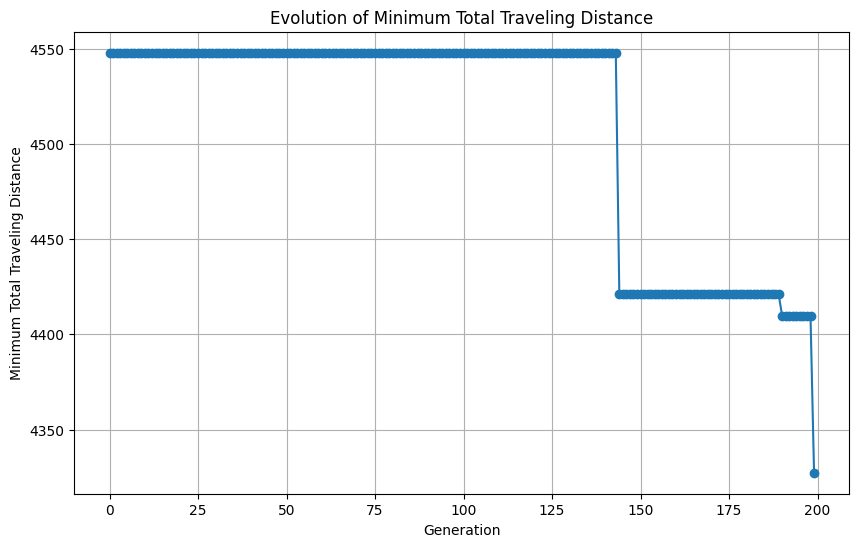

In [21]:
# Define the number of cities and coordinates for dataset 3
num_cities_dataset3 = 101

# Generate dataset 1
dataset3 = generate_problem_instance(num_cities_dataset3)
distances_dataset3 = compute_distances(dataset3)

# Define parameter combinations for dataset 3
parameter_combinations_dataset = [
    {'population_size': 100, 'mutation_rate': 0.01, 'max_generations': 100},
    {'population_size': 200, 'mutation_rate': 0.01, 'max_generations': 150},
    {'population_size': 150, 'mutation_rate': 0.02, 'max_generations': 100},
    {'population_size': 250, 'mutation_rate': 0.02, 'max_generations': 150},
    {'population_size': 100, 'mutation_rate': 0.03, 'max_generations': 150},
    {'population_size': 200, 'mutation_rate': 0.03, 'max_generations': 200}
]

results_dataset = []

# Iterate over parameter combinations and execute genetic algorithm
for params in parameter_combinations_dataset1:
    population_size = params['population_size']
    mutation_rate = params['mutation_rate']
    max_generations = params['max_generations']
    
    best_solution_dataset, best_distances_dataset = genetic_algorithm(distances_dataset3, population_size, mutation_rate, max_generations)
    results_dataset.append({'parameters': params, 'best_solution': best_solution_dataset, 'best_distances': best_distances_dataset})

for i, result in enumerate(results_dataset):
    print(f"Parameters Set {i + 1}:")
    print("Population Size:", result['parameters']['population_size'])
    print("Mutation Rate:", result['parameters']['mutation_rate'])
    print("Max Generations:", result['parameters']['max_generations'])
    print("Best Solution:", result['best_solution'])
    print("Best Distance:", result['best_distances'])
    print()

import matplotlib.pyplot as plt

# Plot the evolution of the minimum total traveling distance
plt.figure(figsize=(10, 6))
plt.plot(best_distances_dataset, marker='o', linestyle='-')
plt.title("Evolution of Minimum Total Traveling Distance")
plt.xlabel("Generation")
plt.ylabel("Minimum Total Traveling Distance")
plt.grid(True)
plt.show()